Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Path to dataset files: C:\Users\sansa\.cache\kagglehub\datasets\kartik2112\fraud-detection\versions\1
test columns : 
 
 Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

 
 train columns : 
 
 Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

 TRAIN: 1,296,675 rows × 22 columns
 TEST: 555,719 rows × 22 columns

 Columns:
['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'trans_nu

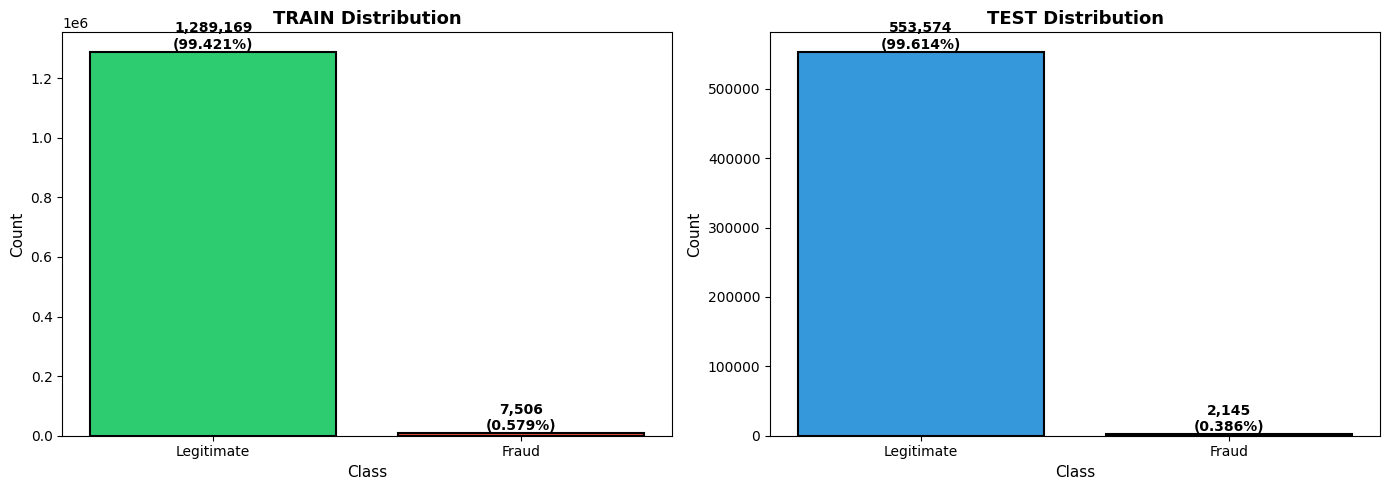


4. KEY FEATURES

 Feature types:
   Numeric: 9
   Categorical: 12

 Amount (amt) statistics:
   Mean: $70.35
   Median: $47.52
   Std: $160.32
   Range: $1.00 - $28948.90

   By class:
   Legitimate: $67.67
   Fraud: $531.32

 Time period:
   From: 2019-01-01 00:00:18
   To: 2020-06-21 12:13:37
   Duration: 537 days

5. DESCRIPTIVE STATISTICS

 Numeric features summary:
                    mean           std           min           max
cc_num      4.171920e+17  1.308806e+18  6.041621e+10  4.992346e+18
amt         7.035104e+01  1.603160e+02  1.000000e+00  2.894890e+04
zip         4.880067e+04  2.689322e+04  1.257000e+03  9.978300e+04
lat         3.853762e+01  5.075808e+00  2.002710e+01  6.669330e+01
long       -9.022634e+01  1.375908e+01 -1.656723e+02 -6.795030e+01
city_pop    8.882444e+04  3.019564e+05  2.300000e+01  2.906700e+06
unix_time   1.349244e+09  1.284128e+07  1.325376e+09  1.371817e+09
merch_lat   3.853734e+01  5.109788e+00  1.902779e+01  6.751027e+01
merch_long -9.022646e+0


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Path to dataset files: C:\Users\sansa\.cache\kagglehub\datasets\kartik2112\fraud-detection\versions\1
test columns : 
 
 Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

 
 train columns : 
 
 Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

 TRAIN: 1,296,675 rows × 22 columns
 TEST: 555,719 rows × 22 columns

 Columns:
['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'trans_nu

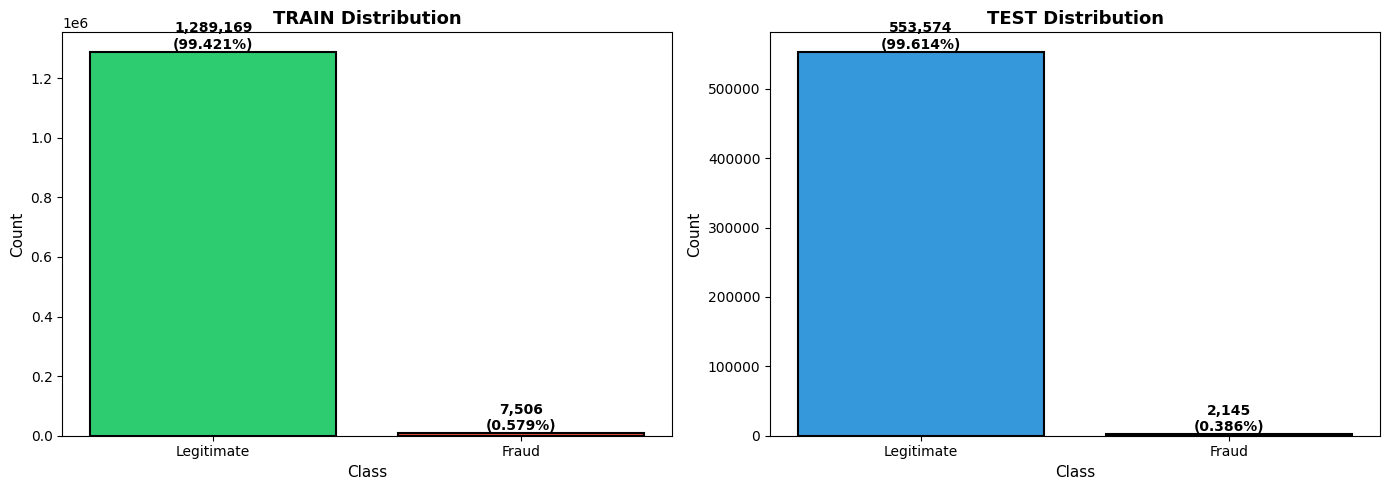


4. KEY FEATURES

 Feature types:
   Numeric: 9
   Categorical: 12

 Amount (amt) statistics:
   Mean: $70.35
   Median: $47.52
   Std: $160.32
   Range: $1.00 - $28948.90

   By class:
   Legitimate: $67.67
   Fraud: $531.32

 Time period:
   From: 2019-01-01 00:00:18
   To: 2020-06-21 12:13:37
   Duration: 537 days

5. DESCRIPTIVE STATISTICS

 Numeric features summary:
                    mean           std           min           max
cc_num      4.171920e+17  1.308806e+18  6.041621e+10  4.992346e+18
amt         7.035104e+01  1.603160e+02  1.000000e+00  2.894890e+04
zip         4.880067e+04  2.689322e+04  1.257000e+03  9.978300e+04
lat         3.853762e+01  5.075808e+00  2.002710e+01  6.669330e+01
long       -9.022634e+01  1.375908e+01 -1.656723e+02 -6.795030e+01
city_pop    8.882444e+04  3.019564e+05  2.300000e+01  2.906700e+06
unix_time   1.349244e+09  1.284128e+07  1.325376e+09  1.371817e+09
merch_lat   3.853734e+01  5.109788e+00  1.902779e+01  6.751027e+01
merch_long -9.022646e+0

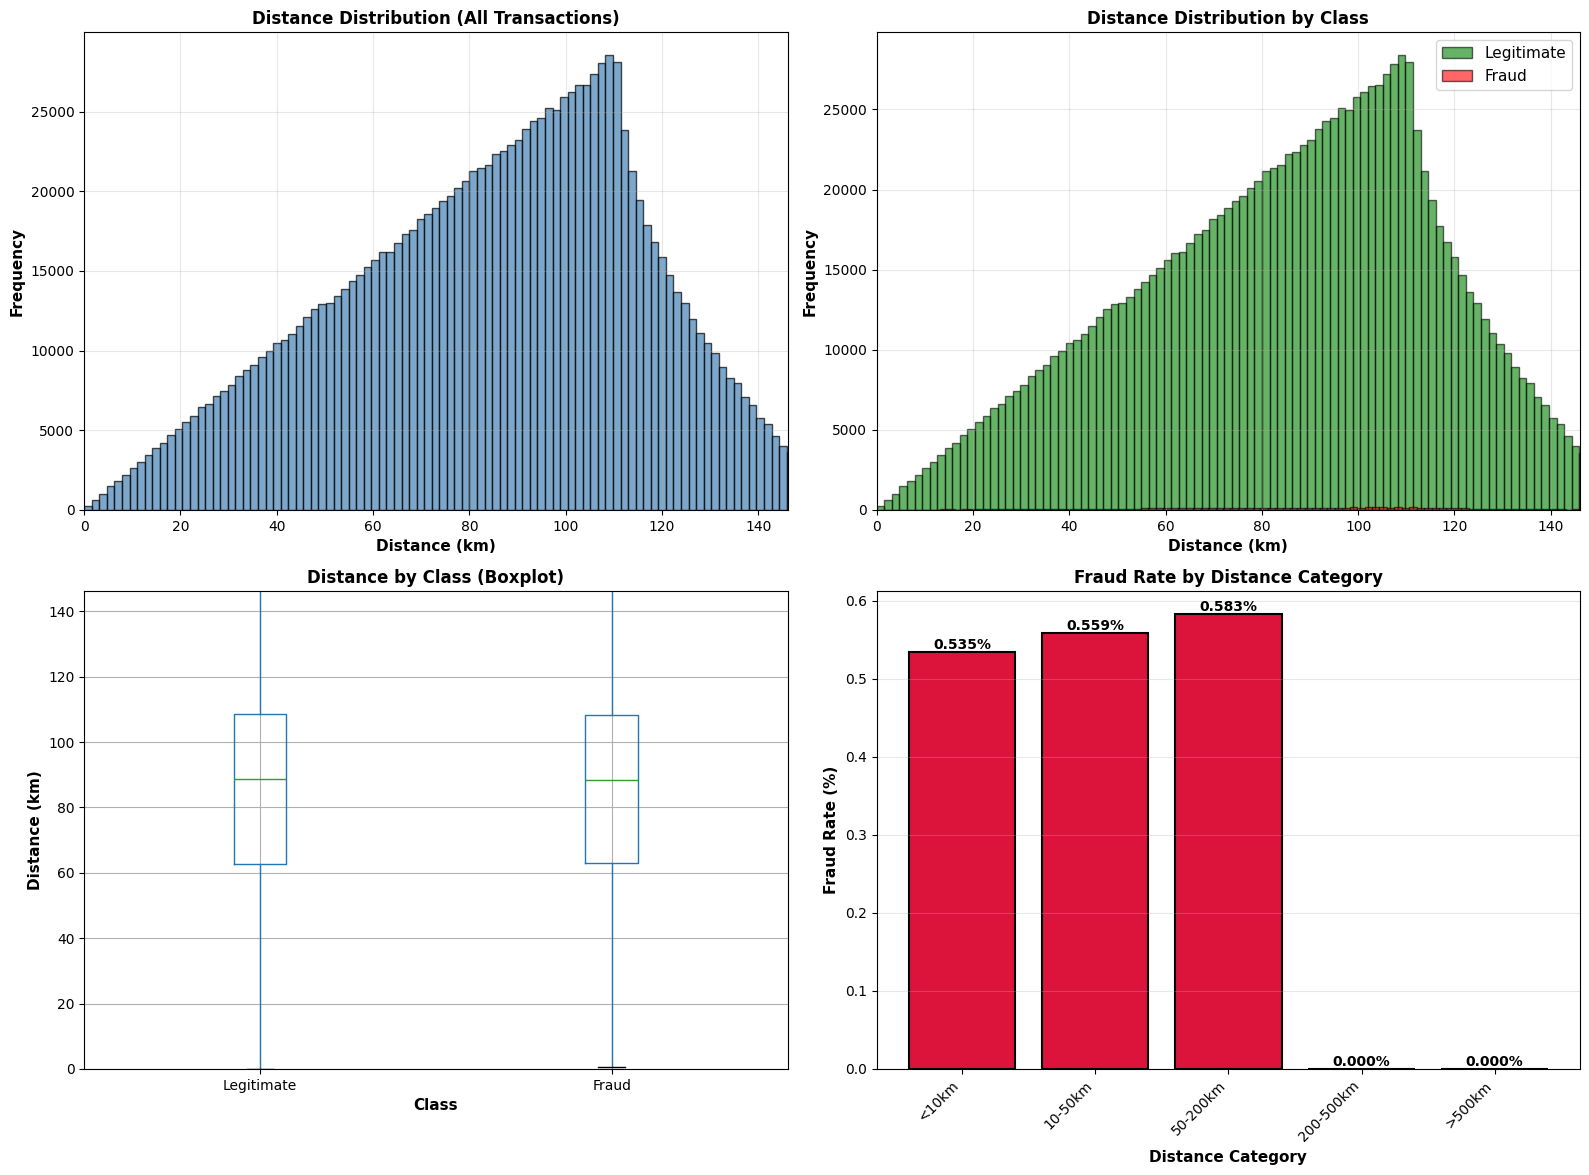


 What we created:
   • distance_km: Euclidean distance between customer and merchant

 Key findings:
   • Mean distance (Legitimate): 84.99 km
   • Mean distance (Fraud): 85.17 km

 Current shapes:
   TRAIN: (1296675, 25)
   TEST: (555719, 25)
Age statistics :
count    1.296675e+06
mean     4.602318e+01
std      1.734874e+01
min      1.800000e+01
25%      3.259959e+01
50%      4.396988e+01
75%      5.707050e+01
max      9.563860e+01
Name: age, dtype: float64
count    555719.000000
mean         46.905700
std          17.400883
min          18.000000
25%          33.448323
50%          44.908966
75%          58.056126
max          96.169747
Name: age, dtype: float64

Distribution :
age_category
Adults (25-50)    718038
Old (>50)         456949
Young (18-25)     121688
Name: count, dtype: int64
age_category
Adults (25-50)    304430
Old (>50)         204922
Young (18-25)      46367
Name: count, dtype: int64

Mean age for each category :
           mean  median    std
is_fraud             

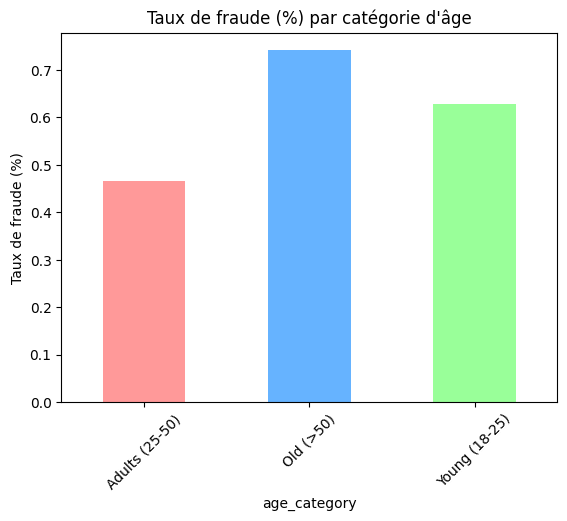


 Categorical columns : 7
 •merchant: 693 unique values
 •category: 14 unique values
 •gender: 2 unique values
 •city: 894 unique values
 •state: 51 unique values
 •job: 494 unique values
 •age_category: 3 unique values

 Gender encoded:
F -> 0
M -> 1

 After encoding:
gender
0    709863
1    586812
Name: count, dtype: int64

 Split complété (avant encodage cible):
   Train full: (1037340, 25) - pour encodage et training
   Validation: (259335, 25) - pour tuning
   Test: (555719, 26) - final eval (inchangé)

 Vérif distribution classes:
   Train full: 6,005 fraudes / 1,037,340 = 0.579%
   Val: 1,501 fraudes / 259,335 = 0.579%
   Test: 2,145 fraudes / 555,719 = 0.386%
    Attention: Légères différences

 Split complété (avant encodage cible):
   Train full: (1037340, 25) - pour encodage et training
   Validation: (259335, 25) - pour tuning
   Test: (555719, 26) - final eval (inchangé)

 Vérif distribution classes:
   Train full: 6,005 fraudes / 1,037,340 = 0.579%
   Val: 1,501 fraudes /

  File "c:\Users\sansa\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")



 AFTER SMOTE:
   Class 0 (legitimate): 1,031,335
   Class 1 (fraud):      309,400
   Ratio: 3.3:1

 Size changes:
   Before: 1,037,340 samples
   After:  1,340,735 samples
   Added:  303,395 synthetic frauds


In [ ]:
%run eda_analysis.ipynb
%run preprocessing_loader_v2.ipynb

**LightGBM CODE**

Librairies


In [2]:

import pandas as pd 
import numpy as np 
from lightgbm import LGBMClassifier
from sklearn.metrics import (f1_score, precision_score, recall_score,roc_auc_score,average_precision_score,confusion_matrix,classification_report)
import matplotlib.pyplot as plt 
import seaborn as sns 
from time import time 
import optuna 

Loading data

In [3]:
# Load training data (Original and SMOTE)

X_train_original = X_train_full
y_train_original = y_train_full

X_train_smote = X_train_resampled
y_train_smote = y_train_resampled

print(f"   Original train: {X_train_original.shape}")
print(f"   SMOTE train: {X_train_smote.shape}")
print(f"   Validation: {X_val.shape}")

   Original train: (1037340, 73)
   SMOTE train: (1340735, 73)
   Validation: (259335, 73)


**-------------------------------------------------- WITHOUT SMOTE --------------------------------------------------** 

First training

In [4]:
# Calculate scale_pos_weight
scale = (y_train_original == 0).sum() / (y_train_original == 1).sum()
print(f"Class imbalance ratio : {scale:.1f}:1")
print(f"scale_pos_weight: {scale:.1f}")


# Initialize LightGBM 

lgbm_base = LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=6,
    num_leaves=31,
    scale_pos_weight = scale,
    min_child_samples=20,
    min_child_weight=0.001,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=0.0,
    n_jobs = -1,
    random_state=42,
)

start_time = time()
lgbm_base.fit(X_train_original, y_train_original)
training_time_base = time() - start_time

print(f"Trained in {training_time_base:.2f} seconds\n \n")

# Predictions

y_pred_base = lgbm_base.predict(X_val)
y_pred_proba_base = lgbm_base.predict_proba(X_val)[:,1]

print(f"F1-Score:          {f1_score(y_val, y_pred_base)*100:.4f} %")
print(f"Precision:         {precision_score(y_val, y_pred_base)*100:.4f} %")
print(f"Recall:            {recall_score(y_val, y_pred_base)*100:.4f} %")
print(f"ROC-AUC:           {roc_auc_score(y_val, y_pred_proba_base)*100:.4f} %")
print(f"PR-AUC:            {average_precision_score(y_val, y_pred_proba_base)*100:.4f} %")

Class imbalance ratio : 171.7:1
scale_pos_weight: 171.7
[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3514
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146017
[LightGBM] [Info] Start training from score -5.146017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

Optimisation using Optuna 

In [5]:
def objective(trial):
    params = {
        'objective':'binary',
        'metric':'binary_logloss',
        'n_estimators': 1000,
        'random_state': 42,
        'n_jobs': -1,
        'scale_pos_weight': scale, 
        
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 5, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
    }
    
    model = LGBMClassifier(**params)

    model.fit(X_train_original, y_train_original, eval_set=[(X_val, y_val)],
              eval_metric='f1')
    
    y_pred = model.predict(X_val)
    score = f1_score(y_val,y_pred)

    return score


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# 3. Afficher les résultats
print("Nombre d'essais terminés: ", len(study.trials))
print("Meilleur essai:")
trial = study.best_trial

print("  Valeur (F1-Score): ", trial.value)
print("  Meilleurs paramètres: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Vous pouvez maintenant utiliser ces meilleurs paramètres pour entraîner votre modèle final
best_params = trial.params

[I 2025-10-14 10:40:26,927] A new study created in memory with name: no-name-93083f59-388a-4baf-9fc6-2582be787320


[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009904 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3514
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146017
[LightGBM] [Info] Start training from score -5.146017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-10-14 10:40:50,788] Trial 0 finished with value: 0.9213857428381079 and parameters: {'learning_rate': 0.06755656762621846, 'num_leaves': 131, 'max_depth': 7, 'min_child_samples': 62, 'subsample': 0.930527447504556, 'colsample_bytree': 0.9443180706199401, 'reg_alpha': 5.595479025205407e-07, 'reg_lambda': 2.397474339365548e-07}. Best is trial 0 with value: 0.9213857428381079.


[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3514
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146017
[LightGBM] [Info] Start training from score -5.146017


[I 2025-10-14 10:41:21,506] Trial 1 finished with value: 0.8938582677165354 and parameters: {'learning_rate': 0.023115469583848008, 'num_leaves': 85, 'max_depth': 12, 'min_child_samples': 95, 'subsample': 0.6255574289941174, 'colsample_bytree': 0.7078375395980263, 'reg_alpha': 4.752224050871842e-06, 'reg_lambda': 0.25531880993177053}. Best is trial 0 with value: 0.9213857428381079.


[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3514
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146017
[LightGBM] [Info] Start training from score -5.146017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

[I 2025-10-14 10:41:58,545] Trial 2 finished with value: 0.7255200405885337 and parameters: {'learning_rate': 0.012625414902340275, 'num_leaves': 78, 'max_depth': 10, 'min_child_samples': 82, 'subsample': 0.9341045629943774, 'colsample_bytree': 0.7952043265154856, 'reg_alpha': 0.30007904307576355, 'reg_lambda': 3.141281611812585e-05}. Best is trial 0 with value: 0.9213857428381079.


[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3514
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146017
[LightGBM] [Info] Start training from score -5.146017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

[I 2025-10-14 10:42:36,352] Trial 3 finished with value: 0.5353510295212106 and parameters: {'learning_rate': 0.1170372826113103, 'num_leaves': 108, 'max_depth': 10, 'min_child_samples': 89, 'subsample': 0.8002715492806529, 'colsample_bytree': 0.6869269218244635, 'reg_alpha': 0.08347509519726834, 'reg_lambda': 0.6565939828862525}. Best is trial 0 with value: 0.9213857428381079.


[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3514
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146017
[LightGBM] [Info] Start training from score -5.146017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-10-14 10:43:03,001] Trial 4 finished with value: 0.6258444105469602 and parameters: {'learning_rate': 0.01456040779191555, 'num_leaves': 134, 'max_depth': 7, 'min_child_samples': 37, 'subsample': 0.6059402475208239, 'colsample_bytree': 0.748832254086666, 'reg_alpha': 3.7832107854721713, 'reg_lambda': 0.00012522218250398523}. Best is trial 0 with value: 0.9213857428381079.


[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3514
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146017
[LightGBM] [Info] Start training from score -5.146017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-10-14 10:43:41,113] Trial 5 finished with value: 0.7797215280257052 and parameters: {'learning_rate': 0.09848798999420565, 'num_leaves': 125, 'max_depth': 11, 'min_child_samples': 90, 'subsample': 0.6478228838543331, 'colsample_bytree': 0.771024332191095, 'reg_alpha': 2.540361795518509e-07, 'reg_lambda': 1.1406302889192954}. Best is trial 0 with value: 0.9213857428381079.


[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013511 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3514
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146017
[LightGBM] [Info] Start training from score -5.146017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-10-14 10:44:01,994] Trial 6 finished with value: 0.6174655908875178 and parameters: {'learning_rate': 0.11403993949595001, 'num_leaves': 133, 'max_depth': 6, 'min_child_samples': 25, 'subsample': 0.9242797677507344, 'colsample_bytree': 0.8477855477525247, 'reg_alpha': 7.283773463878072e-05, 'reg_lambda': 5.135586312711062}. Best is trial 0 with value: 0.9213857428381079.


[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3514
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146017
[LightGBM] [Info] Start training from score -5.146017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-10-14 10:44:29,265] Trial 7 finished with value: 0.3017832647462277 and parameters: {'learning_rate': 0.16464614766939464, 'num_leaves': 35, 'max_depth': 9, 'min_child_samples': 71, 'subsample': 0.7752999608511267, 'colsample_bytree': 0.9018309322760918, 'reg_alpha': 5.205376903609072e-08, 'reg_lambda': 0.06993750751884348}. Best is trial 0 with value: 0.9213857428381079.


[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3514
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146017
[LightGBM] [Info] Start training from score -5.146017


[I 2025-10-14 10:45:03,481] Trial 8 finished with value: 0.8670131458269642 and parameters: {'learning_rate': 0.018809570989737498, 'num_leaves': 106, 'max_depth': 10, 'min_child_samples': 93, 'subsample': 0.6979518640401023, 'colsample_bytree': 0.7103040968864126, 'reg_alpha': 1.961382574723741e-06, 'reg_lambda': 7.523410981311781e-08}. Best is trial 0 with value: 0.9213857428381079.


[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3514
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146017
[LightGBM] [Info] Start training from score -5.146017


[I 2025-10-14 10:45:43,536] Trial 9 finished with value: 0.9163923633969717 and parameters: {'learning_rate': 0.021660241271268248, 'num_leaves': 135, 'max_depth': 12, 'min_child_samples': 29, 'subsample': 0.743512196293866, 'colsample_bytree': 0.9716644992933577, 'reg_alpha': 2.0800732872998765e-08, 'reg_lambda': 1.346427101298092e-07}. Best is trial 0 with value: 0.9213857428381079.


[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3514
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146017
[LightGBM] [Info] Start training from score -5.146017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-10-14 10:46:02,934] Trial 10 finished with value: 0.7088544272136068 and parameters: {'learning_rate': 0.05160229925806537, 'num_leaves': 48, 'max_depth': 5, 'min_child_samples': 50, 'subsample': 0.9840983098300733, 'colsample_bytree': 0.9874824981460304, 'reg_alpha': 0.002244370056570908, 'reg_lambda': 2.450886252297687e-06}. Best is trial 0 with value: 0.9213857428381079.


[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3514
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146017
[LightGBM] [Info] Start training from score -5.146017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-10-14 10:46:36,282] Trial 11 finished with value: 0.9131432317273025 and parameters: {'learning_rate': 0.038038662801089626, 'num_leaves': 145, 'max_depth': 8, 'min_child_samples': 58, 'subsample': 0.828182154664068, 'colsample_bytree': 0.9983893051334742, 'reg_alpha': 1.0108300874893267e-08, 'reg_lambda': 7.506068743122356e-08}. Best is trial 0 with value: 0.9213857428381079.


[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3514
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146017
[LightGBM] [Info] Start training from score -5.146017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-10-14 10:47:04,008] Trial 12 finished with value: 0.902683478823149 and parameters: {'learning_rate': 0.050087344756822964, 'num_leaves': 150, 'max_depth': 7, 'min_child_samples': 44, 'subsample': 0.7258500673402215, 'colsample_bytree': 0.9105485649781723, 'reg_alpha': 2.660349487329635e-05, 'reg_lambda': 1.1839404302151041e-08}. Best is trial 0 with value: 0.9213857428381079.


[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3514
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146017
[LightGBM] [Info] Start training from score -5.146017


[I 2025-10-14 10:47:39,506] Trial 13 finished with value: 0.9265238879736408 and parameters: {'learning_rate': 0.029112696773903473, 'num_leaves': 106, 'max_depth': 12, 'min_child_samples': 68, 'subsample': 0.8543538618454272, 'colsample_bytree': 0.622421779693688, 'reg_alpha': 3.4098470088199887e-07, 'reg_lambda': 0.0058677814819417164}. Best is trial 13 with value: 0.9265238879736408.


[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031784 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3514
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146017
[LightGBM] [Info] Start training from score -5.146017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

[I 2025-10-14 10:48:11,427] Trial 14 finished with value: 0.9406980684513724 and parameters: {'learning_rate': 0.07035442796783611, 'num_leaves': 110, 'max_depth': 8, 'min_child_samples': 70, 'subsample': 0.879186740377975, 'colsample_bytree': 0.6011913852743676, 'reg_alpha': 0.0015492715579606996, 'reg_lambda': 0.003247259830900971}. Best is trial 14 with value: 0.9406980684513724.


[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3514
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146017
[LightGBM] [Info] Start training from score -5.146017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

[I 2025-10-14 10:48:44,810] Trial 15 finished with value: 0.9235793598954931 and parameters: {'learning_rate': 0.03427715367401994, 'num_leaves': 103, 'max_depth': 9, 'min_child_samples': 69, 'subsample': 0.8639819347468944, 'colsample_bytree': 0.6069010331157949, 'reg_alpha': 0.0023820832043182473, 'reg_lambda': 0.005914737296997408}. Best is trial 14 with value: 0.9406980684513724.


[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3514
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146017
[LightGBM] [Info] Start training from score -5.146017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

[I 2025-10-14 10:49:14,129] Trial 16 finished with value: 0.933422999327505 and parameters: {'learning_rate': 0.0733878351275611, 'num_leaves': 73, 'max_depth': 8, 'min_child_samples': 78, 'subsample': 0.8742591377972531, 'colsample_bytree': 0.6001160217980237, 'reg_alpha': 0.0005975259580589464, 'reg_lambda': 0.0034387492272415746}. Best is trial 14 with value: 0.9406980684513724.


[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033777 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3514
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146017
[LightGBM] [Info] Start training from score -5.146017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

[I 2025-10-14 10:49:43,873] Trial 17 finished with value: 0.923949299533022 and parameters: {'learning_rate': 0.07284765611303835, 'num_leaves': 66, 'max_depth': 8, 'min_child_samples': 78, 'subsample': 0.8818373996790733, 'colsample_bytree': 0.6502275377418315, 'reg_alpha': 0.0012791947638968275, 'reg_lambda': 0.011772718356032623}. Best is trial 14 with value: 0.9406980684513724.


[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3514
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146017
[LightGBM] [Info] Start training from score -5.146017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

[I 2025-10-14 10:50:00,868] Trial 18 finished with value: 0.041273111371056444 and parameters: {'learning_rate': 0.18681174195932682, 'num_leaves': 66, 'max_depth': 5, 'min_child_samples': 79, 'subsample': 0.9889397372237361, 'colsample_bytree': 0.6638580835384463, 'reg_alpha': 0.026944903272831187, 'reg_lambda': 0.0009189960668120476}. Best is trial 14 with value: 0.9406980684513724.


[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3514
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146017
[LightGBM] [Info] Start training from score -5.146017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-10-14 10:50:27,367] Trial 19 finished with value: 0.924 and parameters: {'learning_rate': 0.0719506414885211, 'num_leaves': 55, 'max_depth': 8, 'min_child_samples': 100, 'subsample': 0.891374436466801, 'colsample_bytree': 0.836543979809992, 'reg_alpha': 0.00016201562654814242, 'reg_lambda': 1.0198880389870636e-05}. Best is trial 14 with value: 0.9406980684513724.


[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3514
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146017
[LightGBM] [Info] Start training from score -5.146017


[I 2025-10-14 10:50:47,575] Trial 20 finished with value: 0.8260481712756468 and parameters: {'learning_rate': 0.08888196759400831, 'num_leaves': 23, 'max_depth': 6, 'min_child_samples': 51, 'subsample': 0.8198386492153527, 'colsample_bytree': 0.6006179621990287, 'reg_alpha': 0.01561392013150285, 'reg_lambda': 0.0009429617398689754}. Best is trial 14 with value: 0.9406980684513724.


[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3514
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146017
[LightGBM] [Info] Start training from score -5.146017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

[I 2025-10-14 10:51:20,939] Trial 21 finished with value: 0.9089153524299968 and parameters: {'learning_rate': 0.03079799352262549, 'num_leaves': 96, 'max_depth': 9, 'min_child_samples': 69, 'subsample': 0.8469990082473313, 'colsample_bytree': 0.6398601912143027, 'reg_alpha': 1.9434848936122823e-05, 'reg_lambda': 0.015224270773557183}. Best is trial 14 with value: 0.9406980684513724.


[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009579 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3514
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146017
[LightGBM] [Info] Start training from score -5.146017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-10-14 10:51:54,260] Trial 22 finished with value: 0.9467254835425857 and parameters: {'learning_rate': 0.05366986539383552, 'num_leaves': 117, 'max_depth': 11, 'min_child_samples': 60, 'subsample': 0.9011800138508986, 'colsample_bytree': 0.6284601141615074, 'reg_alpha': 0.0005715204955164695, 'reg_lambda': 0.0012942647042777692}. Best is trial 22 with value: 0.9467254835425857.


[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3514
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146017
[LightGBM] [Info] Start training from score -5.146017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-10-14 10:52:29,040] Trial 23 finished with value: 0.9459734964322121 and parameters: {'learning_rate': 0.05158765979808752, 'num_leaves': 119, 'max_depth': 11, 'min_child_samples': 61, 'subsample': 0.9034923093476985, 'colsample_bytree': 0.6698952995367398, 'reg_alpha': 0.0003409054006657595, 'reg_lambda': 0.00032132092505052755}. Best is trial 22 with value: 0.9467254835425857.


[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3514
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146017
[LightGBM] [Info] Start training from score -5.146017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-10-14 10:53:06,679] Trial 24 finished with value: 0.9456521739130435 and parameters: {'learning_rate': 0.054132351607902494, 'num_leaves': 120, 'max_depth': 11, 'min_child_samples': 60, 'subsample': 0.9630020913033521, 'colsample_bytree': 0.675475563136876, 'reg_alpha': 0.006901490245268812, 'reg_lambda': 0.00020875218429170704}. Best is trial 22 with value: 0.9467254835425857.


[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3514
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146017
[LightGBM] [Info] Start training from score -5.146017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-10-14 10:53:44,954] Trial 25 finished with value: 0.9429347826086957 and parameters: {'learning_rate': 0.04839671317570735, 'num_leaves': 120, 'max_depth': 11, 'min_child_samples': 57, 'subsample': 0.9587034786314442, 'colsample_bytree': 0.7232321649874542, 'reg_alpha': 0.012380291875086557, 'reg_lambda': 0.00015180442258190337}. Best is trial 22 with value: 0.9467254835425857.


[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3514
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146017
[LightGBM] [Info] Start training from score -5.146017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-10-14 10:54:21,569] Trial 26 finished with value: 0.9337792642140468 and parameters: {'learning_rate': 0.04091998378404902, 'num_leaves': 118, 'max_depth': 11, 'min_child_samples': 42, 'subsample': 0.9094657204430651, 'colsample_bytree': 0.6671040121471954, 'reg_alpha': 0.8220112847396729, 'reg_lambda': 1.750252906280099e-05}. Best is trial 22 with value: 0.9467254835425857.


[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3514
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146017
[LightGBM] [Info] Start training from score -5.146017


[I 2025-10-14 10:54:53,221] Trial 27 finished with value: 0.9406175771971497 and parameters: {'learning_rate': 0.05894090828236898, 'num_leaves': 92, 'max_depth': 11, 'min_child_samples': 62, 'subsample': 0.9523203773961032, 'colsample_bytree': 0.745015003997893, 'reg_alpha': 0.005703874191515643, 'reg_lambda': 2.18503634798104e-06}. Best is trial 22 with value: 0.9467254835425857.


[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3514
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146017
[LightGBM] [Info] Start training from score -5.146017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-10-14 10:55:31,647] Trial 28 finished with value: 0.9162593678722711 and parameters: {'learning_rate': 0.026558784485282552, 'num_leaves': 118, 'max_depth': 10, 'min_child_samples': 51, 'subsample': 0.9008691663233283, 'colsample_bytree': 0.6789321962072291, 'reg_alpha': 0.0002049183813290709, 'reg_lambda': 0.0005629825362720074}. Best is trial 22 with value: 0.9467254835425857.


[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3514
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146017
[LightGBM] [Info] Start training from score -5.146017


[I 2025-10-14 10:56:09,611] Trial 29 finished with value: 0.9396200814111262 and parameters: {'learning_rate': 0.04144246563223311, 'num_leaves': 142, 'max_depth': 12, 'min_child_samples': 56, 'subsample': 0.9537439662287102, 'colsample_bytree': 0.6332988090982784, 'reg_alpha': 0.07699226971829834, 'reg_lambda': 9.876887045481676e-05}. Best is trial 22 with value: 0.9467254835425857.


[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3514
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146017
[LightGBM] [Info] Start training from score -5.146017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

[I 2025-10-14 10:56:56,382] Trial 30 finished with value: 0.9435374149659864 and parameters: {'learning_rate': 0.04989477857750551, 'num_leaves': 126, 'max_depth': 11, 'min_child_samples': 63, 'subsample': 0.9995926289137596, 'colsample_bytree': 0.6949241413302085, 'reg_alpha': 4.33258238369144e-05, 'reg_lambda': 0.06671698508566103}. Best is trial 22 with value: 0.9467254835425857.


[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3514
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146017
[LightGBM] [Info] Start training from score -5.146017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-10-14 10:57:32,576] Trial 31 finished with value: 0.94385845525689 and parameters: {'learning_rate': 0.0594815935156075, 'num_leaves': 122, 'max_depth': 11, 'min_child_samples': 63, 'subsample': 0.9928477485435191, 'colsample_bytree': 0.6904245702593611, 'reg_alpha': 6.577818667930479e-05, 'reg_lambda': 0.06721548481556802}. Best is trial 22 with value: 0.9467254835425857.


[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3514
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146017
[LightGBM] [Info] Start training from score -5.146017


[I 2025-10-14 10:58:04,381] Trial 32 finished with value: 0.9442934782608695 and parameters: {'learning_rate': 0.06132098803419898, 'num_leaves': 96, 'max_depth': 12, 'min_child_samples': 63, 'subsample': 0.9713625731390125, 'colsample_bytree': 0.728748742176071, 'reg_alpha': 7.880371567762238e-06, 'reg_lambda': 0.03503030723477539}. Best is trial 22 with value: 0.9467254835425857.


[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3514
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146017
[LightGBM] [Info] Start training from score -5.146017


[I 2025-10-14 10:58:38,936] Trial 33 finished with value: 0.9375424304141209 and parameters: {'learning_rate': 0.062419336348017676, 'num_leaves': 89, 'max_depth': 12, 'min_child_samples': 53, 'subsample': 0.9313032406035731, 'colsample_bytree': 0.7300880952828149, 'reg_alpha': 5.038697906667633e-06, 'reg_lambda': 0.0017642542023275664}. Best is trial 22 with value: 0.9467254835425857.


[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3514
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146017
[LightGBM] [Info] Start training from score -5.146017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

[I 2025-10-14 10:59:07,078] Trial 34 finished with value: 0.02420076377523186 and parameters: {'learning_rate': 0.08402240697531467, 'num_leaves': 98, 'max_depth': 10, 'min_child_samples': 46, 'subsample': 0.9651616823756052, 'colsample_bytree': 0.767037242753608, 'reg_alpha': 0.0005809352782457, 'reg_lambda': 0.00025060035104615186}. Best is trial 22 with value: 0.9467254835425857.


[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3514
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146017
[LightGBM] [Info] Start training from score -5.146017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

[I 2025-10-14 10:59:29,560] Trial 35 finished with value: 0.07985110470701248 and parameters: {'learning_rate': 0.1269066958975, 'num_leaves': 83, 'max_depth': 12, 'min_child_samples': 65, 'subsample': 0.9170034529276488, 'colsample_bytree': 0.6549944359995771, 'reg_alpha': 2.9821517894976297e-06, 'reg_lambda': 0.0205421439357643}. Best is trial 22 with value: 0.9467254835425857.


[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3514
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146017
[LightGBM] [Info] Start training from score -5.146017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-10-14 11:00:06,320] Trial 36 finished with value: 0.9362416107382551 and parameters: {'learning_rate': 0.0340786179374416, 'num_leaves': 114, 'max_depth': 11, 'min_child_samples': 37, 'subsample': 0.9383916570763515, 'colsample_bytree': 0.8082120032415838, 'reg_alpha': 0.06303456138340356, 'reg_lambda': 4.082493615501872e-05}. Best is trial 22 with value: 0.9467254835425857.


[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3514
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146017
[LightGBM] [Info] Start training from score -5.146017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

[I 2025-10-14 11:00:45,089] Trial 37 finished with value: 0.7122708039492243 and parameters: {'learning_rate': 0.09958603498779645, 'num_leaves': 129, 'max_depth': 10, 'min_child_samples': 74, 'subsample': 0.9719020997883843, 'colsample_bytree': 0.7081245548636435, 'reg_alpha': 0.25638113187084005, 'reg_lambda': 0.7537474546250487}. Best is trial 22 with value: 0.9467254835425857.


[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3514
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146017
[LightGBM] [Info] Start training from score -5.146017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-10-14 11:01:18,390] Trial 38 finished with value: 0.939816388983339 and parameters: {'learning_rate': 0.05670651767966214, 'num_leaves': 100, 'max_depth': 12, 'min_child_samples': 84, 'subsample': 0.9382860136557865, 'colsample_bytree': 0.7905027389185009, 'reg_alpha': 7.2850740169276626e-06, 'reg_lambda': 0.21083795851523662}. Best is trial 22 with value: 0.9467254835425857.


[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3514
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146017
[LightGBM] [Info] Start training from score -5.146017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-10-14 11:01:53,992] Trial 39 finished with value: 0.7139731165989371 and parameters: {'learning_rate': 0.13554818422075257, 'num_leaves': 112, 'max_depth': 11, 'min_child_samples': 59, 'subsample': 0.8985444748055206, 'colsample_bytree': 0.6842389585981908, 'reg_alpha': 0.0003301911569438692, 'reg_lambda': 7.976625363234496}. Best is trial 22 with value: 0.9467254835425857.


[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3514
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146017
[LightGBM] [Info] Start training from score -5.146017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-10-14 11:02:29,751] Trial 40 finished with value: 0.9423337856173677 and parameters: {'learning_rate': 0.04386964027004358, 'num_leaves': 133, 'max_depth': 10, 'min_child_samples': 73, 'subsample': 0.796290231400249, 'colsample_bytree': 0.7438539848804767, 'reg_alpha': 1.2197307674533755e-06, 'reg_lambda': 7.2915892807127374e-06}. Best is trial 22 with value: 0.9467254835425857.


[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3514
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146017
[LightGBM] [Info] Start training from score -5.146017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-10-14 11:03:06,244] Trial 41 finished with value: 0.9441797140912185 and parameters: {'learning_rate': 0.05957244849138295, 'num_leaves': 123, 'max_depth': 11, 'min_child_samples': 65, 'subsample': 0.975759496951048, 'colsample_bytree': 0.6972473356729537, 'reg_alpha': 1.141730595198738e-05, 'reg_lambda': 0.05958930890365203}. Best is trial 22 with value: 0.9467254835425857.


[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040825 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3514
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146017
[LightGBM] [Info] Start training from score -5.146017


[I 2025-10-14 11:03:42,707] Trial 42 finished with value: 0.7764789231314205 and parameters: {'learning_rate': 0.08715138059670682, 'num_leaves': 141, 'max_depth': 11, 'min_child_samples': 55, 'subsample': 0.9806343024729369, 'colsample_bytree': 0.6264850508126303, 'reg_alpha': 1.0549441546784506e-05, 'reg_lambda': 0.21852501306303346}. Best is trial 22 with value: 0.9467254835425857.


[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035717 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3514
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146017
[LightGBM] [Info] Start training from score -5.146017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-10-14 11:04:22,703] Trial 43 finished with value: 0.9430617115581316 and parameters: {'learning_rate': 0.061795694318215084, 'num_leaves': 127, 'max_depth': 12, 'min_child_samples': 60, 'subsample': 0.9240384238265891, 'colsample_bytree': 0.7205914398853328, 'reg_alpha': 1.3945195726210423e-07, 'reg_lambda': 0.02801621194899273}. Best is trial 22 with value: 0.9467254835425857.


[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3514
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146017
[LightGBM] [Info] Start training from score -5.146017


[I 2025-10-14 11:04:59,789] Trial 44 finished with value: 0.7587496660432808 and parameters: {'learning_rate': 0.010160391350171657, 'num_leaves': 114, 'max_depth': 12, 'min_child_samples': 65, 'subsample': 0.9466460282882743, 'colsample_bytree': 0.6690726067436075, 'reg_alpha': 0.00010945399394688205, 'reg_lambda': 6.162896389982922e-05}. Best is trial 22 with value: 0.9467254835425857.


[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3514
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146017
[LightGBM] [Info] Start training from score -5.146017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-10-14 11:05:35,362] Trial 45 finished with value: 0.9377926421404682 and parameters: {'learning_rate': 0.04715974980336597, 'num_leaves': 106, 'max_depth': 10, 'min_child_samples': 66, 'subsample': 0.9730953503780648, 'colsample_bytree': 0.763877841727614, 'reg_alpha': 1.2123209326436463e-06, 'reg_lambda': 1.9203587150110566}. Best is trial 22 with value: 0.9467254835425857.


[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3514
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146017
[LightGBM] [Info] Start training from score -5.146017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-10-14 11:06:14,717] Trial 46 finished with value: 0.9465076660988075 and parameters: {'learning_rate': 0.05325997126000219, 'num_leaves': 138, 'max_depth': 11, 'min_child_samples': 74, 'subsample': 0.6516062363441084, 'colsample_bytree': 0.6986702324613802, 'reg_alpha': 0.005359387937920799, 'reg_lambda': 0.0002166907834959134}. Best is trial 22 with value: 0.9467254835425857.


[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3514
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146017
[LightGBM] [Info] Start training from score -5.146017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

[I 2025-10-14 11:06:50,394] Trial 47 finished with value: 0.9328010645375915 and parameters: {'learning_rate': 0.03785132151469148, 'num_leaves': 137, 'max_depth': 9, 'min_child_samples': 85, 'subsample': 0.6198418215207175, 'colsample_bytree': 0.6408782379786844, 'reg_alpha': 0.005263795107247799, 'reg_lambda': 0.00024136465981753016}. Best is trial 22 with value: 0.9467254835425857.


[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008596 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3514
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146017
[LightGBM] [Info] Start training from score -5.146017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-10-14 11:07:28,519] Trial 48 finished with value: 0.9410150891632373 and parameters: {'learning_rate': 0.05345138108115787, 'num_leaves': 147, 'max_depth': 12, 'min_child_samples': 75, 'subsample': 0.6628489922045442, 'colsample_bytree': 0.6759878364372103, 'reg_alpha': 0.00044201932849435643, 'reg_lambda': 0.0005283218024544771}. Best is trial 22 with value: 0.9467254835425857.


[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3514
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146017
[LightGBM] [Info] Start training from score -5.146017


[I 2025-10-14 11:08:04,875] Trial 49 finished with value: 0.9221204188481675 and parameters: {'learning_rate': 0.02308904449804543, 'num_leaves': 131, 'max_depth': 11, 'min_child_samples': 48, 'subsample': 0.6942986138450251, 'colsample_bytree': 0.6160296856312287, 'reg_alpha': 0.004413639161180601, 'reg_lambda': 1.7089042827909165e-06}. Best is trial 22 with value: 0.9467254835425857.


Nombre d'essais terminés:  50
Meilleur essai:
  Valeur (F1-Score):  0.9467254835425857
  Meilleurs paramètres: 
    learning_rate: 0.05366986539383552
    num_leaves: 117
    max_depth: 11
    min_child_samples: 60
    subsample: 0.9011800138508986
    colsample_bytree: 0.6284601141615074
    reg_alpha: 0.0005715204955164695
    reg_lambda: 0.0012942647042777692


After optimization

In [7]:
# Initialize LightGBM 

lgbm_base_new = LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05366986539383552,
    max_depth=11,
    num_leaves=117,
    scale_pos_weight = scale,
    min_child_samples=60,
    min_child_weight=0.001,
    subsample=0.9011800138508986,
    colsample_bytree=0.6284601141615074,
    reg_alpha=0.0005715204955164695,
    reg_lambda=0.0012942647042777692,
    n_jobs = -1,
    random_state=42,
)

start_time = time()
lgbm_base_new.fit(X_train_original, y_train_original)
training_time_base = time() - start_time

print(f"Trained in {training_time_base:.2f} seconds\n \n")

# Predictions

y_pred_base_new = lgbm_base_new.predict(X_val)
y_pred_proba_base_new = lgbm_base_new.predict_proba(X_val)[:,1]

print(f"F1-Score:          {f1_score(y_val, y_pred_base_new)*100:.4f} %")
print(f"Precision:         {precision_score(y_val, y_pred_base_new)*100:.4f} %")
print(f"Recall:            {recall_score(y_val, y_pred_base_new)*100:.4f} %")
print(f"ROC-AUC:           {roc_auc_score(y_val, y_pred_proba_base_new)*100:.4f} %")
print(f"PR-AUC:            {average_precision_score(y_val, y_pred_proba_base_new)*100:.4f} %")

[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3514
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146017
[LightGBM] [Info] Start training from score -5.146017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Trained in 29.23 seconds
 

F1-Score:          94.6725 %
Precision:         96.4730 %
Recall:            92.9380 %
ROC-AUC:           99.9219 %
PR-AUC:            97.5634 %


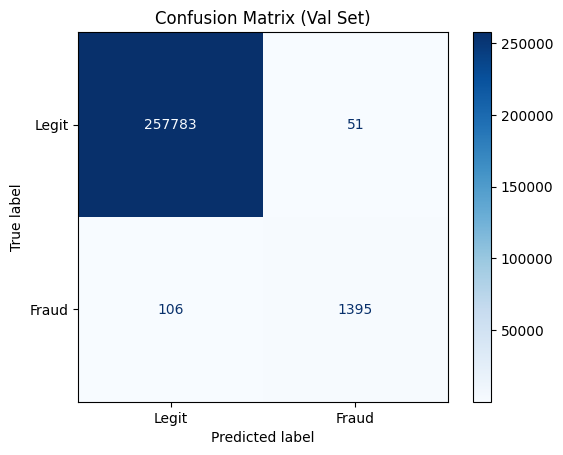

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_val, y_pred_base_new)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Legit', 'Fraud'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (Val Set)')
plt.show()

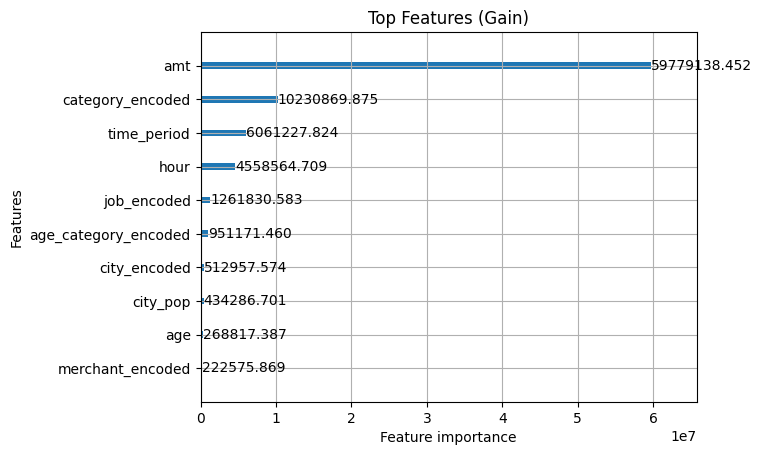

In [16]:
import lightgbm as lgb
lgb.plot_importance(lgbm_base_new, max_num_features=10, importance_type='gain')
plt.title('Top Features (Gain)')
plt.show()